## 构建Two-Head网络对OCSVM进行改进

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# 加载数据
def judge_1(time):
    time = time[:7].replace('-', '')
    if time <= '201803':
        return True
    else:
        return False

def judge_2(time):
    time = time[:7].replace('-', '')
    if time > '201803':
        return True
    else:
        return False

name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}
data_csv = pd.read_csv('../../csv/dataset_handled.csv')
data_2017 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2017']
data_2018 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2018']
data_2019 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2019']
    
data_2018_1 = data_2018[data_2018['first_seen'].apply(judge_1)]
data_2018_2 = data_2018[data_2018['first_seen'].apply(judge_2)]

data_train = data_2017.append(data_2018_1)
data_test_1 = data_2018_2
data_test_2 = data_2019
print(data_train.shape, data_test_1.shape, data_test_2.shape)

(6929, 9) (2668, 9) (3878, 9)


In [3]:
# 对测试集进行下采样
data_train = data_train.sample(frac=1, random_state=1).reset_index(drop=True)
data_test_1 = data_test_1.sample(frac=0.73, random_state=1).reset_index(drop=True)
data_test_2 = data_test_2.sample(frac=0.54, random_state=1).reset_index(drop=True)
print(data_train.shape, data_test_1.shape, data_test_2.shape)

(6929, 9) (1948, 9) (2094, 9)


In [4]:
from utils import *
data_path_1, labels_1 = path_loader(data_train)

In [18]:
from malconv import *
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
model = get_twohead()

# 创建dataset对象
batch_size = 128
max_len = 200000
db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))

# 创建训练过程
optimizer = keras.optimizers.Adam()
loss_sup = keras.losses.CategoricalCrossentropy(from_logits=True)
metrics_train_1 = keras.metrics.CategoricalAccuracy()
metrics_train_2 = keras.metrics.CategoricalAccuracy()
metrics_val_1 = keras.metrics.CategoricalAccuracy()
metrics_val_2 = keras.metrics.CategoricalAccuracy()

epochs = 7
db_train = db_train.batch(batch_size)
db_val = db_val.batch(batch_size)

loss_all = []
acc_all = []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    for step, (x_batch_train, y_batch_train) in enumerate(db_train):
        with tf.GradientTape() as tape:
            out1, out2 = model(x_batch_train)
            loss_value = loss_sup(y_batch_train, out1) + loss_sup(y_batch_train, out2)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        metrics_train_1(y_batch_train, out1)
        metrics_train_2(y_batch_train, out2)
        
        if step % 10 == 0:
            loss_all.append(loss_value)
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
    train_acc_1 = metrics_train_1.result()
    train_acc_2 = metrics_train_2.result()
    print('Training acc over epoch: %s %s' % (float(train_acc_1), float(train_acc_2)))
    metrics_train_1.reset_states()
    metrics_train_2.reset_states()
    
    for x_batch_val, y_batch_val in db_val:
        val_out_1, val_out_2 = model(x_batch_val)
        metrics_val_1(y_batch_val, val_out_1)
        metrics_val_2(y_batch_val, val_out_2)
    
    val_acc_1 = metrics_val_1.result()
    val_acc_2 = metrics_val_2.result()
    acc_all.append(val_acc_1)
    print('Validation acc: %s %s' % (float(val_acc_1), float(val_acc_2))) 
    metrics_val_1.reset_states()
    metrics_val_2.reset_states()

Start of epoch 0
Training loss (for one batch) at step 0: 2.7724313735961914
Training loss (for one batch) at step 10: 2.277169704437256
Training loss (for one batch) at step 20: 1.8324893712997437
Training loss (for one batch) at step 30: 1.0230141878128052
Training loss (for one batch) at step 40: 0.7661075592041016
Training loss (for one batch) at step 50: 0.47801101207733154
Training acc over epoch: 0.7161206603050232 0.7452734708786011
Validation acc: 0.9444364309310913 0.9468898773193359
Start of epoch 1
Training loss (for one batch) at step 0: 0.40231412649154663
Training loss (for one batch) at step 10: 0.31333863735198975
Training loss (for one batch) at step 20: 0.3292226791381836
Training loss (for one batch) at step 30: 0.2111993432044983
Training loss (for one batch) at step 40: 0.20323055982589722
Training loss (for one batch) at step 50: 0.1235547736287117
Training acc over epoch: 0.9565593600273132 0.9580026268959045
Validation acc: 0.9894645810127258 0.9871554374694824

In [19]:
# 保存模型
model.save('../model/malconv_twohead.h5')

In [20]:
from utils import *
from malconv import *
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
from sklearn import metrics

model = get_twohead()
model.load_weights('../model/malconv_twohead.h5')

data_test_1 = pd.read_csv('data_test_1.csv')
ood2label = {True: 0, False: 1}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
paths_test_1 = data_test_1['name'].to_list()

# 批量加载 防止内存过载
batch_size = 200
for idx in range(0, len(paths_test_1), batch_size):
    code_test_tmp = codes_loader(paths_test_1[idx: idx+batch_size])
    labels_test_tmp = np.array(labels_test_1[idx: idx+batch_size])
    discs_sub = get_discs(model, code_test_tmp, labels_test_tmp)
    discs = discs_sub if idx == 0 else np.concatenate((discs, discs_sub), axis=0)

labels_test_1 = np.array(labels_test_1)
test_auc = metrics.roc_auc_score(labels_test_1, discs)
print('Test AUROC: {:.3f}'.format(test_auc))
plot_entropy(discs, labels_test_1, 'entropy_distribution.png')

100%|██████████| 148/148 [00:03<00:00, 46.53it/s]
Test AUROC: 0.918
(1790, 1) [[8.4557116e-02]
 [1.1920929e-06]
 [1.3589859e-05]
 ...
 [7.5995922e-05]
 [5.6028366e-06]
 [2.9639006e-03]]
(158, 1) [[1.81050301e-02]
 [2.56042480e-02]
 [9.05803442e-02]
 [9.05803442e-02]
 [9.05803442e-02]
 [3.52610946e-02]
 [1.48072779e-01]
 [4.36073542e-03]
 [6.83665276e-03]
 [1.96682215e-02]
 [1.34487748e-02]
 [5.13571501e-02]
 [1.42413974e-02]
 [3.62611413e-02]
 [1.39829516e-02]
 [1.65510774e-02]
 [1.98238492e-02]
 [4.49306965e-02]
 [1.47420168e-02]
 [2.48041153e-02]
 [1.56770349e-02]
 [7.47996569e-03]
 [5.78628778e-02]
 [7.74687529e-03]
 [9.12797451e-03]
 [1.80696249e-02]
 [5.55890799e-03]
 [6.77877665e-03]
 [7.25018978e-03]
 [1.57827735e-02]
 [9.05803442e-02]
 [3.99351120e-05]
 [9.58549380e-02]
 [6.68311119e-03]
 [1.63784027e-02]
 [9.05803442e-02]
 [7.38483667e-03]
 [2.91679502e-02]
 [3.36980820e-03]
 [1.02639198e-03]
 [1.28746033e-05]
 [6.96325302e-03]
 [5.91146946e-03]
 [1.79542899e-02]
 [7.04032183e

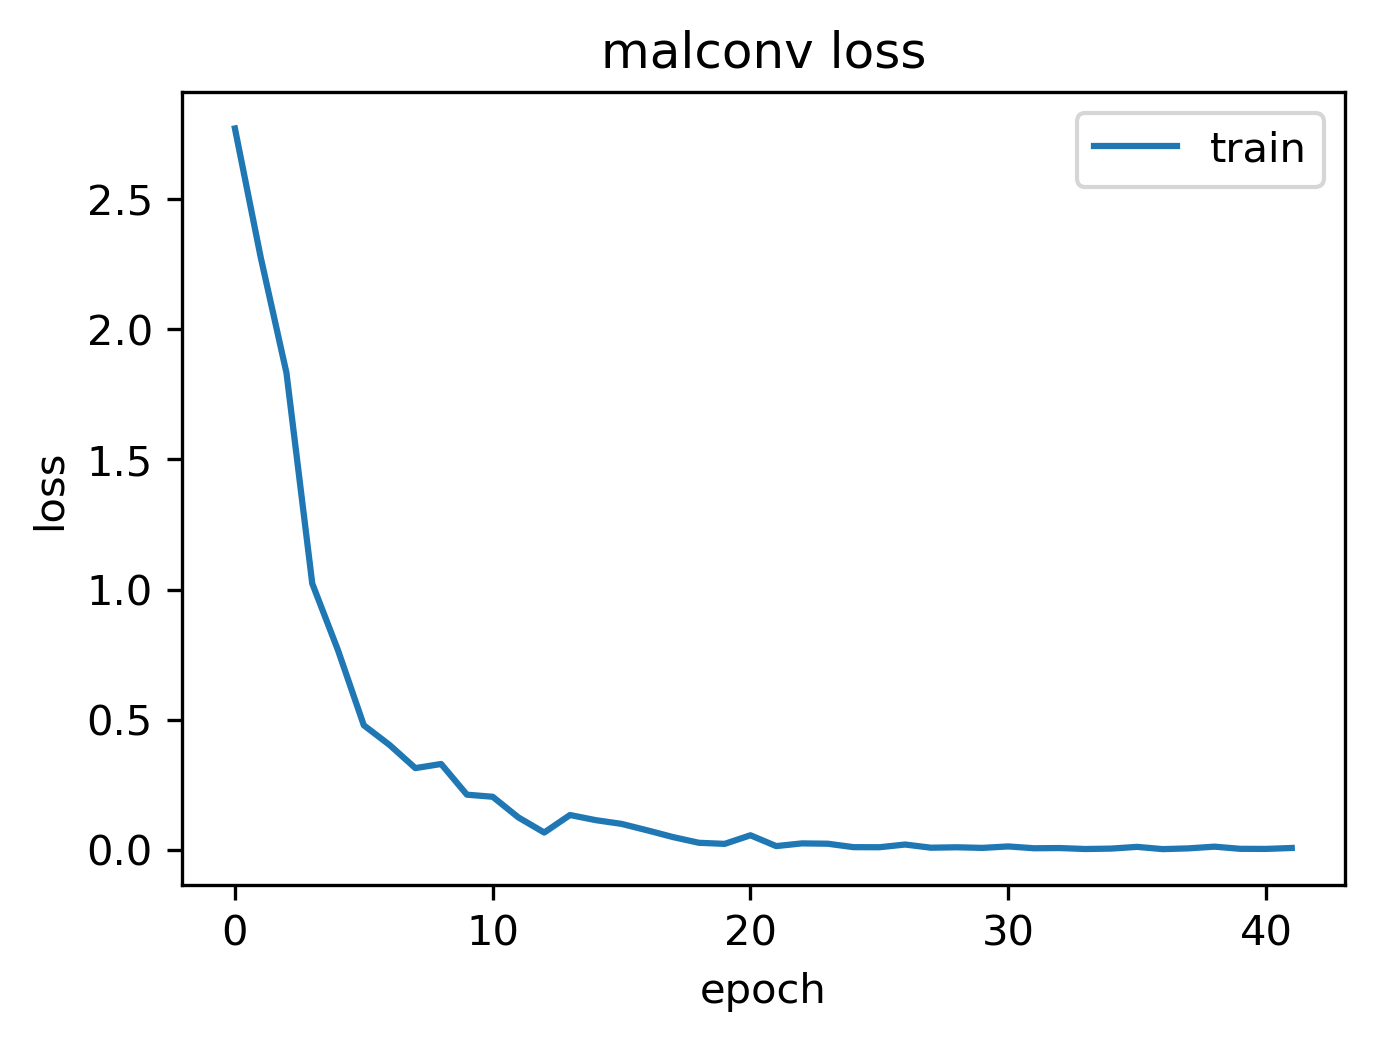

In [21]:
# 绘制损失函数曲线

p1 = plt.figure(figsize=(5, 3.5),dpi=300)
plt.plot(loss_all)
plt.title("malconv loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"],loc="upper right")
plt.savefig("./figures/" + "twohead_loss.png")

## 进行参数微调并改进模型

In [5]:
# 自定义损失函数
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
from malconv import *
from utils import *

model = get_twohead()
class DiscrepancyLoss(keras.losses.Loss):
    def __init__(self, reduction=keras.losses.Reduction.NONE, 
                 from_logits=True, name='membership loss'):
        super().__init__(reduction=reduction, name=name)
    
    def call(self, out1, out2, m=0.3):
        out_1 = K.softmax(out1)
        out_2 = K.softmax(out2)     
        entropy_1 = -out_1 * K.log(out_1)
        entropy_2 = -out_2 * K.log(out_2)
        entropy_1 = K.mean(entropy_1, axis=1)
        entropy_2 = K.mean(entropy_2, axis=1) 
        
        return K.relu(m - K.mean(entropy_1 - entropy_2))

In [6]:
# 加载SVM预测数据
data_test_1 = pd.read_csv('data_test_1.csv')
data_test_unsup = data_test_1[data_test_1['ocsvm']!=0]
codes_unsup = data_test_unsup['name'].to_list()
print(len(codes_unsup))

206


In [7]:
# import importlib
# importlib.reload(utils)
# utils.test()

In [8]:
# 准备训练数据
batch_size = 64
sup_train = tf.data.Dataset.from_generator(svmdata_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
sup_train = sup_train.batch(batch_size)

sup_val = tf.data.Dataset.from_generator(svmdata_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
sup_val = sup_val.batch(batch_size)

unsup_train = tf.data.Dataset.from_generator(codes_generator, args=[codes_unsup], output_types=(tf.float32), output_shapes=((None,)))
unsup_train = unsup_train.batch(batch_size)

In [9]:
# 准备测试数据
data_test_1 = pd.read_csv('data_test_1.csv')
ood2label = {True: 0, False: 1}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
paths_test_1 = data_test_1['name'].to_list()
# codes_test_1 = codes_loader(paths_test_1)
labels_test_1 = np.array(labels_test_1)

In [10]:
# 开始训练
import visdom
from tqdm import tqdm

model = get_twohead()
model.load_weights('../model/malconv_twohead.h5')
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_sup = keras.losses.CategoricalCrossentropy(from_logits=True)
loss_unsup = DiscrepancyLoss()
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()
vis = visdom.Visdom(server='http://localhost')

print('>> Fine-tune a Model.')
best_auc = 0.
num_epochs = 10
iters = 0
plot_data = {'X': [], 'Y': [], 'legend': ['Sup. Loss', 'Unsup. Loss', 'Tot. Loss']}
for epoch in range(num_epochs):

    for step, batch in enumerate(zip(sup_train, unsup_train)):
        
        (x_batch_train, y_batch_train), (x_batch_train_unsup) = batch
        print('Start of epoch %d step %d' % (epoch,step))
        with tf.GradientTape() as tape:
            out_1, out_2 = model(x_batch_train)
            loss_sup_value = loss_sup(y_batch_train, out_1) + loss_sup(y_batch_train, out_2)
            out_1, out_2 = model(x_batch_train_unsup)
            loss_unsup_value = loss_unsup(out_1, out_2)
            loss_value = loss_sup_value + loss_unsup_value
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # 可视化
        if step % 2 == 0:
            
            loss_sup_value = loss_sup_value.numpy()
            loss_unsup_value = loss_unsup_value.numpy()
            loss_value = loss_value.numpy()
            
            plot_data['X'].append(iters)
            plot_data['Y'].append([
                loss_sup_value, loss_unsup_value, loss_value])
            vis.line(
                X=np.stack([np.array(plot_data['X'])] * len(plot_data['legend']), 1),
                Y=np.array(plot_data['Y']),
                opts={
                    'title': 'Loss over Time',
                    'legend': plot_data['legend'],
                    'xlabel': 'Iterations',
                    'ylabel': 'Loss',
                    'width': 900,
                    'height': 300,
                },
                win=2
            )
        iters += 1 
        
        # 使用test1数据集进行验证
        if step % 2 == 0:
            # 批量加载 防止内存过载
            batch_size = 20
            for idx in tqdm(range(0, len(paths_test_1), batch_size)):
                code_test_tmp = codes_loader(paths_test_1[idx: idx+batch_size])
                out_1_tmp, out_2_tmp = model.predict(code_test_tmp)
                out_1_tmp = keras.backend.softmax(out_1_tmp).numpy()
                out_2_tmp = keras.backend.softmax(out_2_tmp).numpy()

                entropy_1_tmp = np.max(out_1_tmp, axis=1)
                entropy_2_tmp = np.max(out_2_tmp, axis=1)

                discs_tmp = np.abs(entropy_1_tmp - entropy_2_tmp).reshape((-1, 1))
                discs = discs_tmp if idx == 0 else np.concatenate((discs, discs_tmp), axis=0)
        
            labels = np.array(labels_test_1)
            test_auc = metrics.roc_auc_score(labels, discs)
            print('Test AUROC: {:.3f}'.format(test_auc))
            if test_auc > best_auc:
                best_auc = test_auc
                model.save('../model/twohead_best.h5')

Setting up a new session...
>> Fine-tune a Model.
Start of epoch 0 step 0
100%|██████████| 98/98 [00:48<00:00,  2.01it/s]
Test AUROC: 0.935
Start of epoch 0 step 1
Start of epoch 0 step 2
100%|██████████| 98/98 [00:48<00:00,  2.02it/s]
Test AUROC: 0.948
Start of epoch 0 step 3
Start of epoch 1 step 0
100%|██████████| 98/98 [00:48<00:00,  2.04it/s]
Test AUROC: 0.953
Start of epoch 1 step 1
Start of epoch 1 step 2
100%|██████████| 98/98 [00:48<00:00,  2.02it/s]
Test AUROC: 0.953
Start of epoch 1 step 3
Start of epoch 2 step 0
100%|██████████| 98/98 [00:49<00:00,  2.00it/s]
Test AUROC: 0.951
Start of epoch 2 step 1
Start of epoch 2 step 2
100%|██████████| 98/98 [00:48<00:00,  2.01it/s]
Test AUROC: 0.950
Start of epoch 2 step 3
Start of epoch 3 step 0
100%|██████████| 98/98 [00:48<00:00,  2.01it/s]
Test AUROC: 0.950
Start of epoch 3 step 1
Start of epoch 3 step 2
100%|██████████| 98/98 [00:49<00:00,  1.99it/s]
Test AUROC: 0.953
Start of epoch 3 step 3
Start of epoch 4 step 0
100%|█████████

In [6]:
model.load_weights('../model/malconv_twohead.h5')

from sklearn import metrics
auc_res, discs = get_auc(model, codes_test_1, labels_test_1)
print('Final AUROC: {:.3f}'.format(auc_res))
plot_entropy(discs, labels_test_1, 'entropy_distribution.png')

Final AUROC: 0.959


In [11]:
# 对第一个测试集进行测试
from sklearn import metrics
from tqdm import tqdm

model.load_weights('../model/twohead_best.h5')

data_test_1 = pd.read_csv('data_test_1.csv')
ood2label = {True: 0, False: 1}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
paths_test_1 = data_test_1['name'].to_list()

# 批量加载 防止内存过载
batch_size = 200
for idx in tqdm(range(0, len(paths_test_1), batch_size)):
    code_test_tmp = codes_loader(paths_test_1[idx: idx+batch_size])
    labels_test_tmp = np.array(labels_test_1[idx: idx+batch_size])
    discs_sub = get_discs(model, code_test_tmp, labels_test_tmp)
    discs = discs_sub if idx == 0 else np.concatenate((discs, discs_sub), axis=0)

labels_test_1 = np.array(labels_test_1)
test_auc = metrics.roc_auc_score(labels_test_1, discs)
print('Test AUROC: {:.3f}'.format(test_auc))
plot_entropy(discs, labels_test_1, 'entropy_distribution_1_best.png')

Test AUROC: 0.953


0.12011173184357542
0.029897511


0.8803901437371663

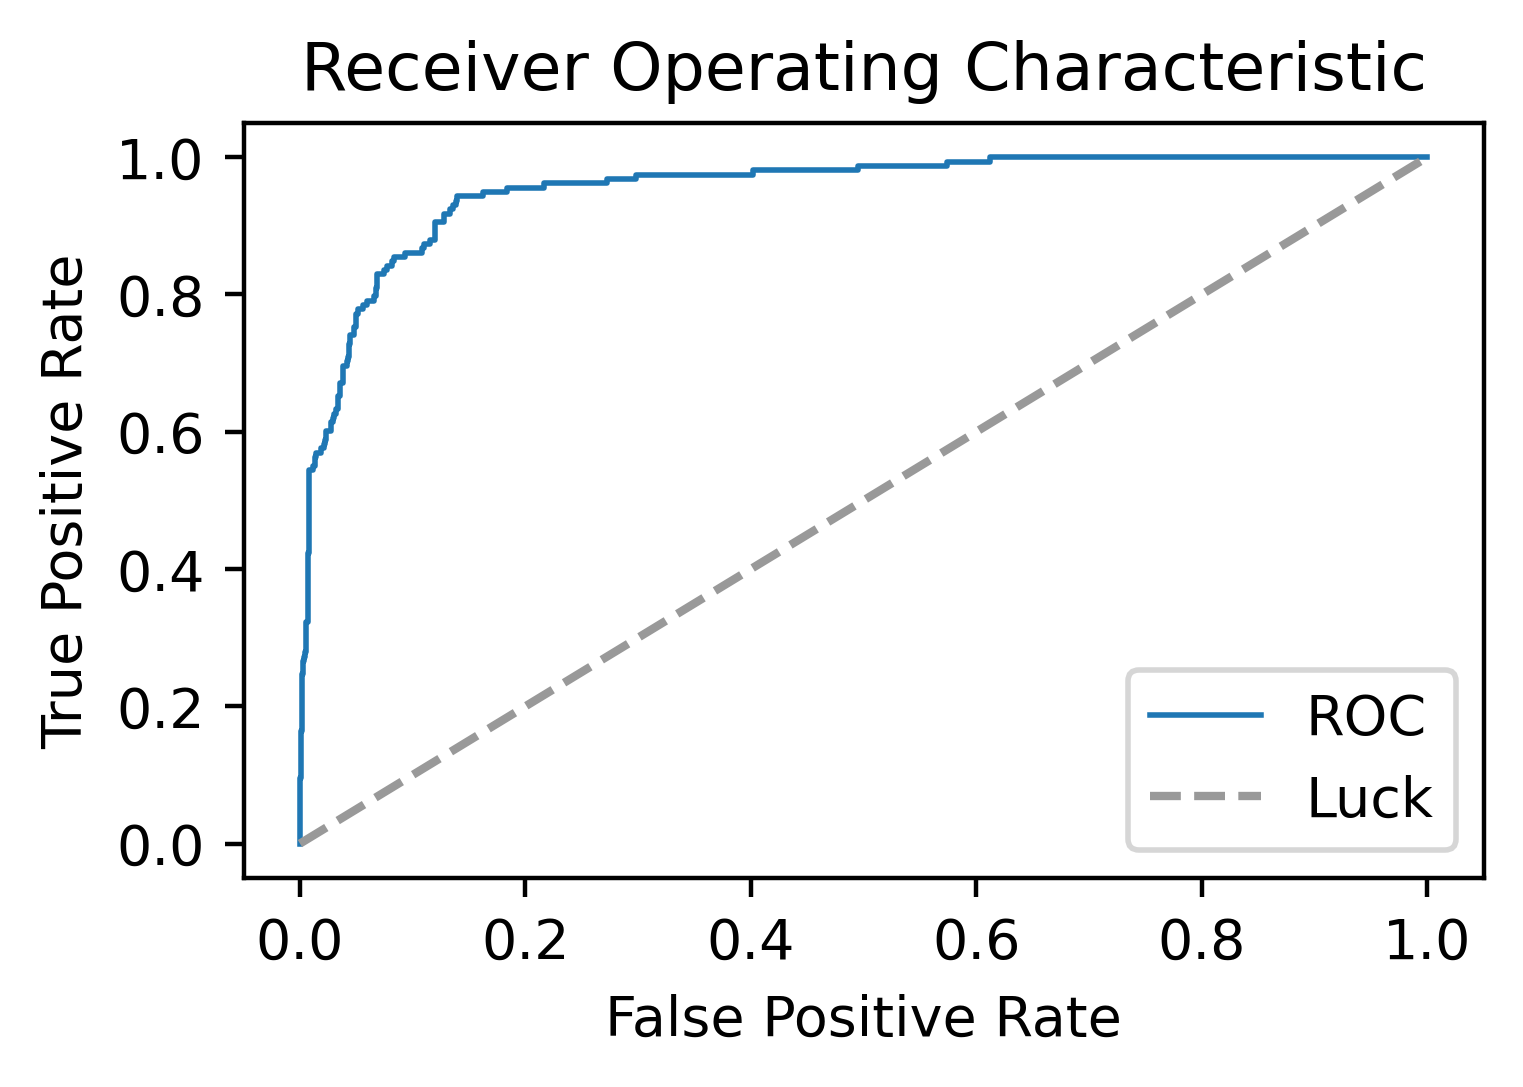

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels_test_1, discs)
roc_auc = auc(fpr, tpr)
for i in range(len(fpr)):
    if fpr[i] + tpr[i] >= 1:
        i = i - 1
        break
print(fpr[i])

# 画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来

p1 = plt.figure(figsize=(4, 2.5),dpi=400)
plt.plot(fpr, tpr, lw=1, label='ROC')
# 画对角线
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./figures/twohead_roc.png')

print(thresholds[i])
pred = discs>thresholds[i]
pred = pred.astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(labels_test_1, pred)

In [14]:
from sklearn.metrics import classification_report

labels_pre_id = data_test_1['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[discs<thresholds[i]]

model_pre = keras.models.load_model('../model/malconv_split.h5')
bool_code = discs<thresholds[i]
bool_code = bool_code.reshape(-1)
# print(type(bool_code), bool_code)


# 分批预测
batch_size = 200
for idx in tqdm(range(0, len(paths_test_1), batch_size)):
    code_test_tmp = codes_loader(paths_test_1[idx: idx+batch_size])
    code_id_tmp = code_test_tmp[bool_code[idx: idx+batch_size]]
    y_pred_tmp = model_pre.predict(code_id_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)

# codes_pre_id = codes_test_1[bool_code.reshape(-1)]
# y_pred = model_pre.predict(codes_pre_id)
# y_pred = np.argmax(y_pred, 1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    backdoor     0.9722    0.9964    0.9842       562
        worm     0.9978    0.9978    0.9978       461
      trojan     0.9963    0.9645    0.9802       282
       virus     0.9965    0.9792    0.9878       289

    accuracy                         0.9881      1594
   macro avg     0.9907    0.9845    0.9875      1594
weighted avg     0.9883    0.9881    0.9881      1594



In [15]:
print(classification_report(labels_test_1, pred, digits=4))

              precision    recall  f1-score   support

           0     0.9881    0.8804    0.9312      1790
           1     0.3938    0.8797    0.5440       158

    accuracy                         0.8804      1948
   macro avg     0.6909    0.8801    0.7376      1948
weighted avg     0.9399    0.8804    0.8998      1948



In [16]:
# 对第二个子集进行测试
from sklearn import metrics
from tqdm import tqdm

model.load_weights('../model/twohead_best.h5')

data_test_2 = pd.read_csv('data_test_2.csv')
ood2label = {True: 0, False: 1}
labels_test_2 = data_test_2['id'].map(lambda x: ood2label[x])
labels_test_2 = labels_test_2.to_list()
paths_test_2 = data_test_2['name'].to_list()

# 批量加载 防止内存过载
batch_size = 200
for idx in tqdm(range(0, len(paths_test_2), batch_size)):
    code_test_tmp = codes_loader(paths_test_2[idx: idx+batch_size])
    labels_test_tmp = np.array(labels_test_2[idx: idx+batch_size])
    discs_sub = get_discs(model, code_test_tmp, labels_test_tmp)
    discs = discs_sub if idx == 0 else np.concatenate((discs, discs_sub), axis=0)

labels_test_2 = np.array(labels_test_2)
test_auc = metrics.roc_auc_score(labels_test_2, discs)
print('Test AUROC: {:.3f}'.format(test_auc))
plot_entropy(discs, labels_test_2, 'entropy_distribution_2_best.png')

100%|██████████| 11/11 [01:50<00:00, 10.07s/it]
Test AUROC: 0.865


0.23474663908996898


0.7655205348615091

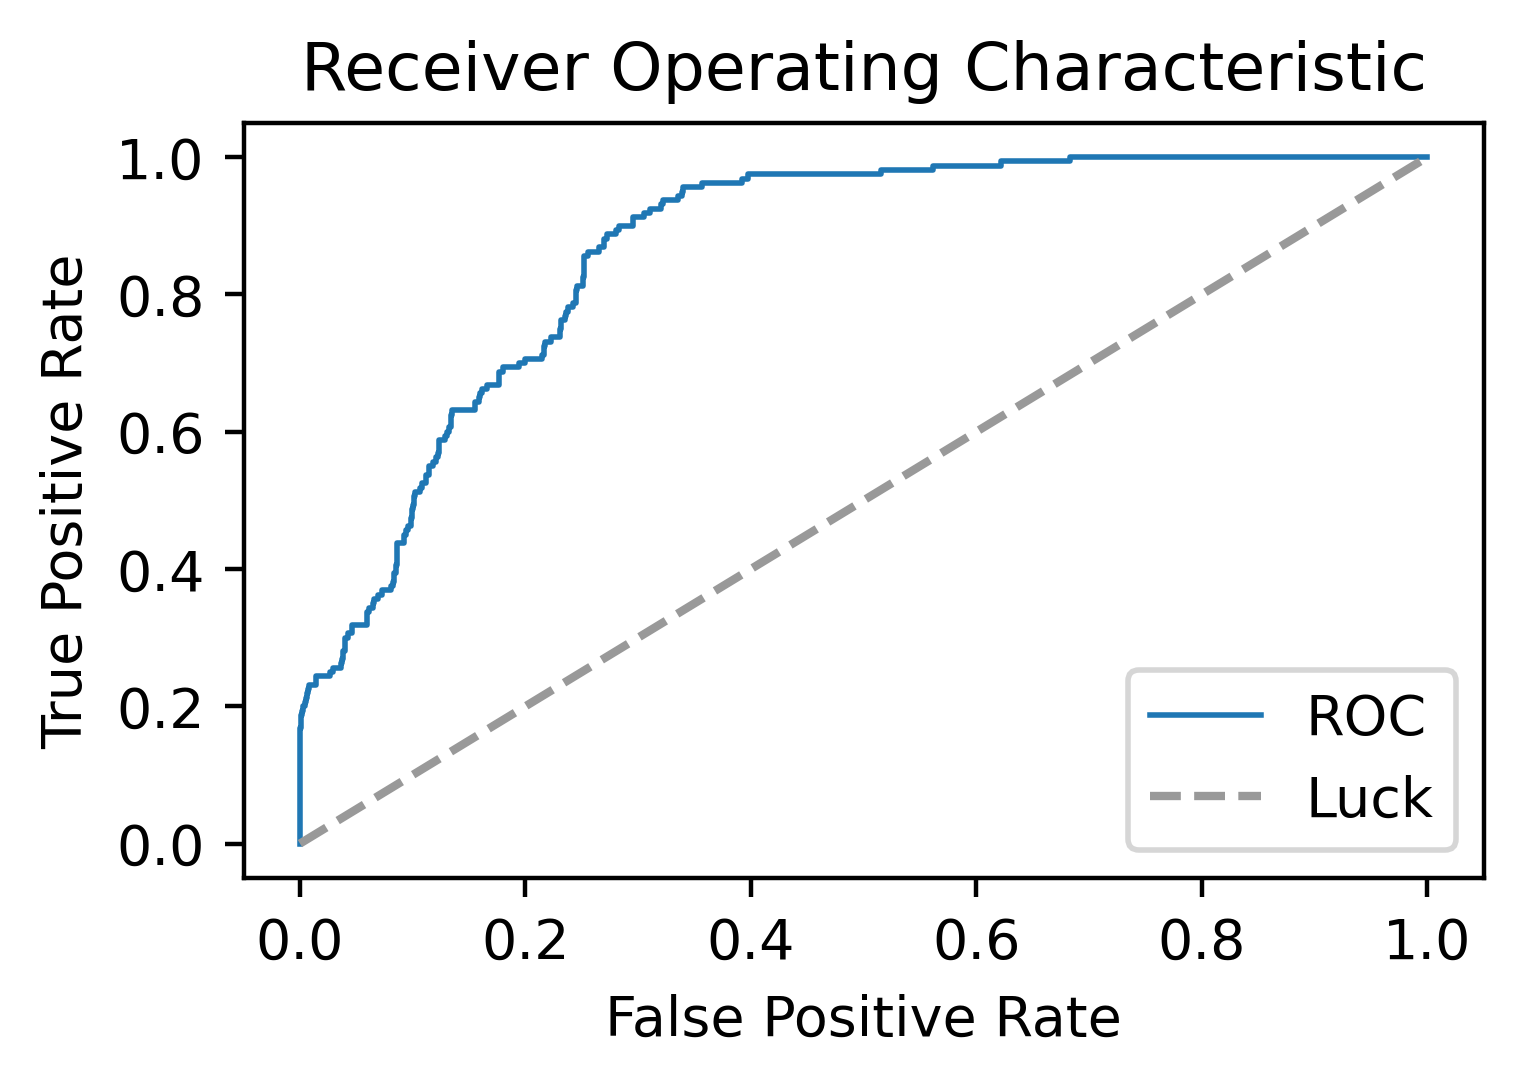

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels_test_2, discs)
roc_auc = auc(fpr, tpr)
for i in range(len(fpr)):
    if fpr[i] + tpr[i] >= 1:
        i = i - 1
        break
print(fpr[i])

# 画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
p1 = plt.figure(figsize=(4, 2.5),dpi=400)
plt.plot(fpr, tpr, lw=1, label='ROC')
# 画对角线
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./figures/twohead_roc_2.png')

pred = discs>thresholds[i]
pred = pred.astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(labels_test_2, pred)

In [19]:
from sklearn.metrics import classification_report

labels_pre_id = data_test_2['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[discs<thresholds[i]]

model_pre = keras.models.load_model('../model/malconv_split.h5')
bool_code = discs<thresholds[i]
bool_code = bool_code.reshape(-1)
# print(type(bool_code), bool_code)


# 分批预测
batch_size = 200
for idx in tqdm(range(0, len(paths_test_2), batch_size)):
    code_test_tmp = codes_loader(paths_test_2[idx: idx+batch_size])
    code_id_tmp = code_test_tmp[bool_code[idx: idx+batch_size]]
    y_pred_tmp = model_pre.predict(code_id_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)

target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

100%|██████████| 11/11 [01:48<00:00,  9.89s/it]              precision    recall  f1-score   support

    backdoor     0.9800    0.9850    0.9825       399
        worm     0.9515    0.9842    0.9676       379
      trojan     0.9849    0.9655    0.9751       406
       virus     0.9847    0.9641    0.9743       334

    accuracy                         0.9750      1518
   macro avg     0.9753    0.9747    0.9749      1518
weighted avg     0.9753    0.9750    0.9750      1518




In [15]:
print(classification_report(labels_test_2, pred, digits=4))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1868
           1       0.34      0.81      0.48       226

    accuracy                           0.81      2094
   macro avg       0.66      0.81      0.68      2094
weighted avg       0.90      0.81      0.84      2094

